In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autosklearn.experimental.askl2 import AutoSklearn2Classifier #-> Need to restart runtime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('dataset.csv')
data.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,3418,Female,0.0,No,No,26.0,Yes,No,DSL,No,Yes,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),131.55,1483.7,No
1,6865,Male,0.0,No,No,39.0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),79.61,2737.31,No
2,2799,Male,0.0,No,No,1.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),9.26,9.26,No
3,1584,Male,0.0,Yes,Yes,66.0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),42.14,1689.19,No
4,9997,Male,0.0,No,No,56.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,No,Electronic check,126.24,5608.69,No


In [3]:
def replace_values(df, columns):
  for c in columns:
    df[c] = df[c].replace('No', 0)
    df[c] = df[c].replace('Yes', 1)
    df[c] = df[c].replace(regex=r'No', value=0)
    df[c] = df[c].replace(np.nan, 0)
  return df

In [4]:
def transform(df):
  df = replace_values(df, [
                           'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'ONLINESECURITY', 
                           'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 
                           'PAPERLESSBILLING', 'CHURN'])
  
  df = df.fillna({'GENDER': df.mode()['GENDER'][0]})
  df = df.fillna({'SENIORCITIZEN': df.mode()['SENIORCITIZEN'][0]})
  df = df.fillna({'TENURE': df.mode()['TENURE'][0]})
  df = df.fillna({'INTERNETSERVICE': df.mode()['INTERNETSERVICE'][0]}) 
  df = df.fillna({'CONTRACT': df.mode()['CONTRACT'][0]}) 
  df = df.fillna({'PAYMENTMETHOD': df.mode()['PAYMENTMETHOD'][0]})
  df['GENDER'] = df['GENDER'].replace('Female', 0)
  df['GENDER'] = df['GENDER'].replace('Male', 1)
  df['MONTHLYCHARGES'] = pd.to_numeric(df['MONTHLYCHARGES'], errors='coerce')
  df['TOTALCHARGES'] = pd.to_numeric(df['TOTALCHARGES'], errors='coerce')
  #df['INTERNETSERVICE'] = df['INTERNETSERVICE'].replace(regex=r'No', value=df.mode()['INTERNETSERVICE'][0])
  df = df.fillna({'MONTHLYCHARGES': df['MONTHLYCHARGES'].median()})
  df = df.fillna({'TOTALCHARGES': df['TOTALCHARGES'].median()})

  MONTHLYCHARGES_rs = RobustScaler( 
        with_centering=True, 
        with_scaling=True, 
        quantile_range=(25.0, 75.0), 
        copy=False, 
  ) 

  MONTHLYCHARGES_ss = StandardScaler()
  
  TOTALCHARGES_rs = RobustScaler( 
        with_centering=True, 
        with_scaling=True, 
        quantile_range=(25.0, 75.0), 
        copy=False, 
  ) 

  TOTALCHARGES_ss = StandardScaler()

  TENURE_rs = RobustScaler( 
        with_centering=True, 
        with_scaling=True, 
        quantile_range=(25.0, 75.0), 
        copy=False, 
  ) 

  TENURE_ss = StandardScaler()

  df['MONTHLYCHARGES'] = MONTHLYCHARGES_rs.fit_transform(df['MONTHLYCHARGES'].values.reshape(-1, 1))
  df['TOTALCHARGES'] = TOTALCHARGES_rs.fit_transform(df['TOTALCHARGES'].values.reshape(-1, 1))
  df['TENURE'] = TENURE_rs.fit_transform(df['TENURE'].values.reshape(-1, 1))

  df['MONTHLYCHARGES'] = MONTHLYCHARGES_ss.fit_transform(df['MONTHLYCHARGES'].values.reshape(-1, 1))
  df['TOTALCHARGES'] = TOTALCHARGES_ss.fit_transform(df['TOTALCHARGES'].values.reshape(-1, 1))
  df['TENURE'] = TENURE_ss.fit_transform(df['TENURE'].values.reshape(-1, 1))

  df = pd.get_dummies(df, columns=['INTERNETSERVICE', 'CONTRACT', 'PAYMENTMETHOD'])
  df = df.drop(columns=['ID'])
  
  return df


In [5]:
df = data.copy()
df = transform(df)

In [6]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,INTERNETSERVICE_DSL,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_Month-to-month,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Bank transfer (automatic),PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,0,0.0,0.0,0.0,-0.233687,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.475496,-0.344891,0,1,0,0,1,0,0,0,1,0,0
1,1,0.0,0.0,0.0,0.298228,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.214051,0.213826,0,0,1,0,1,0,0,0,1,0,0
2,1,0.0,0.0,0.0,-1.256600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.148006,-1.002029,0,0,0,1,1,0,0,0,1,0,0
3,1,0.0,1.0,1.0,1.402975,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.711496,-0.253307,0,0,0,1,0,0,1,0,1,0,0
4,1,0.0,0.0,0.0,0.993809,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.405001,1.493562,0,0,1,0,1,0,0,0,0,1,0


In [7]:
df.isnull().sum()

GENDER                                     0
SENIORCITIZEN                              0
PARTNER                                    0
DEPENDENTS                                 0
TENURE                                     0
PHONESERVICE                               0
MULTIPLELINES                              0
ONLINESECURITY                             0
ONLINEBACKUP                               0
DEVICEPROTECTION                           0
TECHSUPPORT                                0
STREAMINGTV                                0
STREAMINGMOVIES                            0
PAPERLESSBILLING                           0
MONTHLYCHARGES                             0
TOTALCHARGES                               0
CHURN                                      0
INTERNETSERVICE_DSL                        0
INTERNETSERVICE_Fiber optic                0
INTERNETSERVICE_No                         0
CONTRACT_Month-to-month                    0
CONTRACT_One year                          0
CONTRACT_T

In [8]:
np.unique(df['CHURN'], return_counts=True)

(array([0, 1]), array([3337, 1211]))

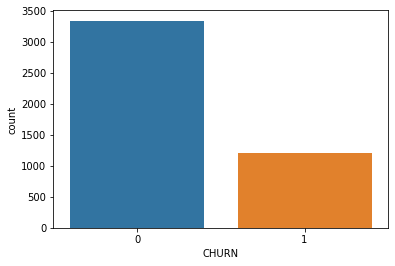

In [9]:
sns.countplot(x=df['CHURN'])

In [10]:
X = df.drop(columns=['CHURN'])
y = df['CHURN']

In [11]:
y.shape

(4548,)

In [12]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)
y.shape

(6674,)

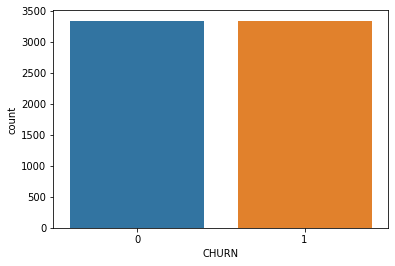

In [13]:
sns.countplot(x=y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

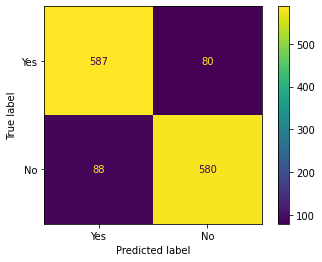

In [30]:
kfold = model_selection.KFold(n_splits=20)
dtc = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=dtc, n_estimators=num_trees, random_state=0)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_macro')
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
cm = confusion_matrix(y_test, y_hat, labels=[1, 0])
cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Yes', 'No'])
cm.plot()
plt.show()

In [31]:
print(results.mean())
print(accuracy_score(y_test, y_hat))
print(f1_score(y_test, y_hat, pos_label=0, average='binary'))

0.841071449999699
0.8741573033707866
0.8734939759036144


In [33]:
answers = pd.read_csv('ANSWERS.csv')
answers.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,TO_FILL
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,TO_FILL
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,TO_FILL
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,TO_FILL
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,TO_FILL


In [34]:
answers.isnull().sum()

ID                  0
GENDER              0
SENIORCITIZEN       0
PARTNER             0
DEPENDENTS          0
TENURE              0
PHONESERVICE        0
MULTIPLELINES       0
INTERNETSERVICE     0
ONLINESECURITY      0
ONLINEBACKUP        0
DEVICEPROTECTION    0
TECHSUPPORT         0
STREAMINGTV         0
STREAMINGMOVIES     0
CONTRACT            0
PAPERLESSBILLING    0
PAYMENTMETHOD       0
MONTHLYCHARGES      0
TOTALCHARGES        0
CHURN               0
dtype: int64

In [36]:
result = answers.copy()
result = transform(result)
result.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,INTERNETSERVICE_DSL,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_Month-to-month,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Bank transfer (automatic),PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,0,0,0,0,-1.225825,1,0,0,0,0,0,0,0,0,-0.573706,-1.001549,TO_FILL,0,0,1,1,0,0,0,0,1,0
1,1,0,0,0,0.530228,1,0,0,0,0,0,0,0,0,-0.503221,-0.624549,TO_FILL,0,0,1,0,0,1,1,0,0,0
2,1,0,1,0,1.128883,1,1,1,1,0,0,0,1,0,1.853028,1.564730,TO_FILL,0,1,0,0,1,0,0,0,1,0
3,1,0,0,1,-1.305645,1,1,0,0,0,0,0,0,1,0.621380,-0.979729,TO_FILL,0,1,0,1,0,0,0,0,1,0
4,1,0,0,0,-0.387709,1,0,1,0,0,1,0,0,0,0.134977,-0.446673,TO_FILL,1,0,0,1,0,0,0,0,1,0


In [38]:
attrs = result.drop(columns=['CHURN'])
preds = model.predict(attrs)
preds

array([1, 0, 0, ..., 0, 0, 0])

In [40]:
answers['CHURN'] = preds

In [41]:
answers.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,1
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,0
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,0
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,1
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,0


In [42]:
answers['CHURN'] = answers['CHURN'].replace(0, 'No')
answers['CHURN'] = answers['CHURN'].replace(1, 'Yes')

In [43]:
answers.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,Yes
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,No
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,No
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,Yes
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,No


In [44]:
answers.to_csv('result.csv', index=False)

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,6946,Female,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,51.71,90.81,Yes
1,2228,Male,0,No,No,47,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),57.05,979.6,No
2,3591,Male,0,Yes,No,62,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Yes,One year,No,Electronic check,235.56,6140.91,No
3,1153,Male,0,No,Yes,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,142.25,142.25,Yes
4,5227,Male,0,No,No,24,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Electronic check,105.40,1398.95,No


In [18]:
# num_trees = 70
# model = AdaBoostClassifier(n_estimators=num_trees, random_state=0)
# results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_macro')
# model.fit(X_train, y_train)
# y_hat = model.predict(X_test)
# cm = confusion_matrix(y_test, y_hat, labels=[1, 0])
# cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Yes', 'No'])
# cm.plot()
# plt.show()

In [19]:
# print(results.mean())
# print(accuracy_score(y_test, y_hat))
# print(f1_score(y_test, y_hat, pos_label=1, average='binary'))

In [20]:
# estimators = []
# model1 = LogisticRegression()
# estimators.append(('logistic', model1))
# model2 = DecisionTreeClassifier()
# estimators.append(('cart', model2))
# model3 = SVC()
# estimators.append(('svm', model3))
# # create the ensemble model
# model = VotingClassifier(estimators)
# results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)

# model.fit(X_train, y_train)
# y_hat = model.predict(X_test)
# cm = confusion_matrix(y_test, y_hat, labels=[1, 0])
# cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Yes', 'No'])
# cm.plot()
# plt.show()

In [21]:
# print(results.mean())
# print(accuracy_score(y_test, y_hat))
# print(f1_score(y_test, y_hat, pos_label=0, average='binary'))

In [22]:
# from tensorflow import keras

# model = keras.Sequential([
#     keras.layers.Dense(64, activation='relu', input_dim = X_train.shape[1]),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=300, verbose=False)

In [23]:
# y_hat = model.predict(X_test)

In [24]:
# y_pred = []
# for element in y_hat:
#   if element > 0.5:
#     y_pred.append(1)
#   else:
#     y_pred.append(0)

In [25]:
# result = model.evaluate(X_test, y_test)
# dict(zip(model.metrics_names, result))
# print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test, y_pred, pos_label=0, average='binary'))